In [16]:
%load_ext autoreload
%autoreload 2
from add_thin.data import DataModule
from pathlib import Path
import torch
import torch.nn as nn
import math
from add_thin.diffusion.model import AddThin
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
dm = DataModule(root=Path('data'), name="taxi",
                train_size=0.6, val_size=0.2,batch_size=32)
dm.prepare_data()

In [18]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [38]:
class Time_embed(nn.Module):
    def __init__(self, d_model):
        super(Time_embed, self).__init__()
        self.d_model = d_model

        
    def forward(self, x):
        x_time = x.time
        x_time = x_time.to(device)
        result = x_time.unsqueeze(-1).repeat(1, 1, self.d_model)
        result[:, :, 0::2] = torch.sin(result[:, :, 0::2])
        result[:, :, 1::2] = torch.cos(result[:, :, 1::2])
        mask = x.mask.unsqueeze(-1).float()
        return result * mask

In [62]:
class N_embed(nn.Module):
    def __init__(self, d_model):
        super(N_embed, self).__init__()
        self.d_model = d_model
        
    def forward(self, x):
        x = x.to(device)
        x = x.unsqueeze(-1)
        result = x.unsqueeze(-1).repeat(1, 1, self.d_model)
        result[:, :, 0::2] = torch.sin(result[:, :, 0::2])
        result[:, :, 1::2] = torch.cos(result[:, :, 1::2])
        return result

In [63]:
class PredictPossionRate(nn.Module):
    def __init__(self, 
                 d_model, 
                 nhead, 
                 dim_feedforward, 
                 dropout, 
                 batch_first,
                 num_layers = 3):
        super(PredictPossionRate, self).__init__()
        
        self.transformer_encoder_layer = TransformerEncoderLayer(d_model = d_model,
                                        nhead = nhead,
                                        dim_feedforward = dim_feedforward,
                                        dropout = dropout,
                                        batch_first = batch_first)
        
        self.transformer_encoder = TransformerEncoder(self.transformer_encoder_layer, num_layers)
        
        
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
        self.time_encoder = Time_embed(d_model)
        self.kept_embs = nn.Embedding(2, d_model)
        self.n_embed = N_embed(d_model)
        
        
        
    def forward(self, x,n):
        
        time_embeds = self.time_encoder(x)
        pad_mask = x.mask.unsqueeze(-1).float()
        x_kept_cond = x.kept
        if x.kept is not None:
            kept_mask = x.kept.long()
            kept_embs = self.kept_embs(kept_mask)
            pm = pad_mask.repeat(1,1,kept_embs.shape[-1])
            kept_embs = kept_embs * pm
        n = self.n_embed(n)
        if x.kept is not None:
            concat_embeds = time_embeds + kept_embs + n
        else:
            concat_embeds = time_embeds + n
        #concat_embeds = time_embeds * kept_embs + n
        b,seq_len, d_model = time_embeds.shape
        mask = torch.zeros((seq_len, seq_len), device = x.time.device)
        pad_mask = pad_mask.squeeze(-1)
        pad_mask[pad_mask == 0] = float('-inf')
        pad_mask[pad_mask == 1] = 0
        transformer_embeds = self.transformer_encoder(concat_embeds, 
                                                      mask = mask,
                                                      src_key_padding_mask = pad_mask)
        avg_emb = transformer_embeds.sum(1) / torch.clamp(x.mask.sum(-1)[..., None], min=1)
        return avg_emb
    

In [64]:
class GaussianMixtures(nn.Module):
    def __init__(self, n_components):
        super(GaussianMixtures, self).__init__()
        self.n_components = n_components
        self.mus = nn.Parameter(torch.randn(n_components,))
        self.sigmas = nn.Parameter(torch.abs(torch.randn(n_components,)))
        self.weights = nn.Parameter(torch.abs(torch.randn(n_components,)))
        
        
        
    def forward(self, seq_lens):
        mix = D.Categorical(probs=self.weights)
        comp = D.Normal(loc=self.mus, scale=self.sigmas)
        mixture = D.MixtureSameFamily(mix, comp)
        log_probs = mixture.log_prob(seq_lens)
        return log_probs
        
    
    

In [77]:
d_model = 64
nhead = 4
dim_feedforward = 128
dropout = 0.0
batch_first = True
num_layers = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PredictPossionRate(d_model = d_model, 
                 nhead = nhead, 
                 dim_feedforward = dim_feedforward, 
                 dropout = dropout, 
                 batch_first = batch_first,
                 num_layers = num_layers).to(device)
gmm = GaussianMixtures(n_components=8).to(device)


#log_like_model = MixtureIntensity(n_components=8, embedding_size=32).to(device)

#include both models in the optimizer
optimizer = optim.Adam(list(model.parameters()), lr=0.0001)


In [78]:
add_thin_model = AddThin(classifier_model =None,
        intensity_model = None,
        max_time = 24,
        n_max = 140,
        steps = 1,
        hidden_dims = 32,
        emb_dim = 32,
        encoder_layer = 3,
        kernel_size =  5,
        forecast=None,
        simulation_steps = 5,
).to(device)

In [79]:
dm.n_max

140

In [80]:
from tqdm import tqdm
from IPython.display import clear_output
from torch.distributions import Poisson


In [81]:
def kl_divergence_loss(z_mean, z_logvar):
    # Compute the KL-divergence loss
    # z_mean: (batch_size, latent_dim)
    # z_logvar: (batch_size, latent_dim)

    # Compute variance from log variance
    z_var = torch.exp(z_logvar)

    # Compute KL divergence
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_var, dim=1)
    kl_loss = torch.mean(kl_loss)  # Take mean over the batch

    return kl_loss


In [82]:
#set detect anomaly to True
with torch.autograd.detect_anomaly():
    train_loss_list = []
    val_loss_list = []
    for epoch in tqdm(range(200)):
        train_batch_list = []
        for batch in train_loader:
            
            optimizer.zero_grad()
            n = torch.randint(low = 0, high = 10, size=(len(batch),), device=batch.time.device)
            #n = torch.ones_like(n) * 3
            #l = n.shape[0]
            #n[:l//3] = n[:l//3] * 3
            #n[l//3:2*l//3] =  n[l//3:2*l//3] * 2
            #n[2*l//3:] = n[2*l//3:] * 1
            n = n/10 
            x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
            x_n.to(device)
            x_0_thin.to(device)
            context_embs = model(x_n,n)
            main_embs = x_0_thin_embeds(x_0_thin, n)
            preds, z_mean, z_logvar = variational_auto_encoder(main_embs, context_embs)
            lens = 140 * preds
            loss = F.mse_loss(lens.float().squeeze(), x_0_thin.mask.sum(-1).float())
            kl_div = kl_divergence_loss(z_mean, z_logvar)
            loss = loss + kl_div
            loss.backward()
            optimizer.step()
            # if epoch is divisble by 100 print the loss
                
            train_batch_list.append(loss.item())
            
        with torch.no_grad():
            #evaluate on val_loader
            val_batch_list = []
            for batch in val_loader:
                n = torch.randint(low = 0, high = 10, size=(len(batch),), device=batch.time.device)
                n = n/10
                x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
                x_n.to(device)
                x_0_thin.to(device)
                context_embs = model(x_n,n)
                main_embs = x_0_thin_embeds(x_0_thin, n)
                preds, z_mean, z_logvar = variational_auto_encoder(main_embs, context_embs)
                lens = 140 * preds
                loss = F.mse_loss(lens.float().squeeze(), x_0_thin.mask.sum(-1).float())
                kl_div = kl_divergence_loss(z_mean, z_logvar)
                loss = loss + kl_div
                val_batch_list.append(loss.item())
                
            
        train_loss_list.append(sum(train_batch_list)/len(train_batch_list))
        val_loss_list.append(sum(val_batch_list)/len(val_batch_list))
        if epoch % 10 == 0:
                #clear output of jupyter notebook screen
                clear_output(wait=True)
                
                print("epoch: ", epoch, "val_loss: ", val_loss_list[-1])
                print("kl_div: ", kl_div)
                print("loss: ", loss)
        
        

C:\Users\Nishant\AppData\Local\Temp\ipykernel_19104\2881210339.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
  0%|          | 1/200 [00:01<04:23,  1.32s/it]

epoch:  0 val_loss:  2893.77392578125
epoch:  0 val_loss:  2893.77392578125
kl_div:  tensor(27.6864, device='cuda:0')
loss:  tensor(2893.7739, device='cuda:0')


  1%|          | 2/200 [00:02<03:45,  1.14s/it]

epoch:  1 val_loss:  1954.8502197265625


  2%|▏         | 3/200 [00:03<03:38,  1.11s/it]

epoch:  2 val_loss:  1998.061279296875


  2%|▏         | 4/200 [00:04<03:38,  1.12s/it]

epoch:  3 val_loss:  2277.028564453125


  2%|▎         | 5/200 [00:05<03:41,  1.14s/it]

epoch:  4 val_loss:  2890.927978515625


  3%|▎         | 6/200 [00:06<03:48,  1.18s/it]

epoch:  5 val_loss:  1628.000732421875


  4%|▎         | 7/200 [00:08<03:45,  1.17s/it]

epoch:  6 val_loss:  1862.2110595703125


  4%|▍         | 8/200 [00:09<03:50,  1.20s/it]

epoch:  7 val_loss:  1794.62060546875


  4%|▍         | 9/200 [00:10<03:47,  1.19s/it]

epoch:  8 val_loss:  1763.309814453125


  5%|▌         | 10/200 [00:11<03:43,  1.17s/it]

epoch:  9 val_loss:  1516.9295654296875


  6%|▌         | 11/200 [00:12<03:44,  1.19s/it]

epoch:  10 val_loss:  2266.546630859375
epoch:  10 val_loss:  2266.546630859375
kl_div:  tensor(27.9980, device='cuda:0')
loss:  tensor(2266.5466, device='cuda:0')


  6%|▌         | 12/200 [00:13<03:31,  1.13s/it]

epoch:  11 val_loss:  1460.7078857421875


  6%|▋         | 13/200 [00:14<03:27,  1.11s/it]

epoch:  12 val_loss:  1843.0048828125


  7%|▋         | 14/200 [00:16<03:26,  1.11s/it]

epoch:  13 val_loss:  1640.7994384765625


  8%|▊         | 15/200 [00:17<03:24,  1.11s/it]

epoch:  14 val_loss:  1579.232177734375


  8%|▊         | 16/200 [00:18<03:18,  1.08s/it]

epoch:  15 val_loss:  1694.510009765625


  8%|▊         | 17/200 [00:19<03:14,  1.07s/it]

epoch:  16 val_loss:  1809.27001953125


  9%|▉         | 18/200 [00:20<03:14,  1.07s/it]

epoch:  17 val_loss:  2137.576904296875


 10%|▉         | 19/200 [00:21<03:18,  1.09s/it]

epoch:  18 val_loss:  1316.5260009765625


 10%|█         | 20/200 [00:22<03:23,  1.13s/it]

epoch:  19 val_loss:  2040.25341796875


 10%|█         | 21/200 [00:23<03:27,  1.16s/it]

epoch:  20 val_loss:  1354.41357421875
epoch:  20 val_loss:  1354.41357421875
kl_div:  tensor(10.7601, device='cuda:0')
loss:  tensor(1354.4136, device='cuda:0')


 11%|█         | 22/200 [00:25<03:28,  1.17s/it]

epoch:  21 val_loss:  1526.93994140625


 12%|█▏        | 23/200 [00:26<03:26,  1.17s/it]

epoch:  22 val_loss:  1243.7628173828125


 12%|█▏        | 24/200 [00:27<03:26,  1.17s/it]

epoch:  23 val_loss:  1417.43310546875


 12%|█▎        | 25/200 [00:28<03:23,  1.16s/it]

epoch:  24 val_loss:  1714.9608154296875


 13%|█▎        | 26/200 [00:29<03:23,  1.17s/it]

epoch:  25 val_loss:  1118.4278564453125


 14%|█▎        | 27/200 [00:30<03:25,  1.19s/it]

epoch:  26 val_loss:  1363.3907470703125


 14%|█▍        | 28/200 [00:32<03:26,  1.20s/it]

epoch:  27 val_loss:  1388.8846435546875


 14%|█▍        | 29/200 [00:33<03:22,  1.19s/it]

epoch:  28 val_loss:  1406.9615478515625


 15%|█▌        | 30/200 [00:34<03:23,  1.20s/it]

epoch:  29 val_loss:  1154.811279296875


 16%|█▌        | 31/200 [00:35<03:16,  1.16s/it]

epoch:  30 val_loss:  1385.8555908203125
epoch:  30 val_loss:  1385.8555908203125
kl_div:  tensor(19.0699, device='cuda:0')
loss:  tensor(1385.8556, device='cuda:0')


 16%|█▌        | 32/200 [00:36<03:16,  1.17s/it]

epoch:  31 val_loss:  1222.9652099609375


 16%|█▋        | 33/200 [00:38<03:18,  1.19s/it]

epoch:  32 val_loss:  1430.994140625


 17%|█▋        | 34/200 [00:39<03:17,  1.19s/it]

epoch:  33 val_loss:  1197.6441650390625


 18%|█▊        | 35/200 [00:40<03:14,  1.18s/it]

epoch:  34 val_loss:  861.1390991210938


 18%|█▊        | 36/200 [00:41<03:13,  1.18s/it]

epoch:  35 val_loss:  1207.11669921875


 18%|█▊        | 37/200 [00:42<03:12,  1.18s/it]

epoch:  36 val_loss:  1121.4564208984375


 19%|█▉        | 38/200 [00:44<03:13,  1.20s/it]

epoch:  37 val_loss:  1063.86328125


 20%|█▉        | 39/200 [00:45<03:09,  1.18s/it]

epoch:  38 val_loss:  1169.8466796875


 20%|██        | 40/200 [00:46<03:11,  1.19s/it]

epoch:  39 val_loss:  1141.788818359375


 20%|██        | 41/200 [00:47<03:07,  1.18s/it]

epoch:  40 val_loss:  1255.1156005859375
epoch:  40 val_loss:  1255.1156005859375
kl_div:  tensor(14.7626, device='cuda:0')
loss:  tensor(1255.1156, device='cuda:0')


 21%|██        | 42/200 [00:48<03:05,  1.18s/it]

epoch:  41 val_loss:  1420.3516845703125


 22%|██▏       | 43/200 [00:49<03:05,  1.18s/it]

epoch:  42 val_loss:  958.5498657226562


 22%|██▏       | 44/200 [00:50<02:55,  1.12s/it]

epoch:  43 val_loss:  967.4411010742188


 22%|██▎       | 45/200 [00:51<02:51,  1.11s/it]

epoch:  44 val_loss:  1147.197265625


 23%|██▎       | 46/200 [00:53<02:50,  1.11s/it]

epoch:  45 val_loss:  964.7749633789062


 24%|██▎       | 47/200 [00:54<02:53,  1.13s/it]

epoch:  46 val_loss:  1036.2178955078125


 24%|██▍       | 48/200 [00:55<02:55,  1.15s/it]

epoch:  47 val_loss:  1206.47021484375


 24%|██▍       | 49/200 [00:56<02:52,  1.14s/it]

epoch:  48 val_loss:  1409.3389892578125


 25%|██▌       | 50/200 [00:57<02:56,  1.17s/it]

epoch:  49 val_loss:  866.9365234375


 26%|██▌       | 51/200 [00:59<02:57,  1.19s/it]

epoch:  50 val_loss:  954.0177612304688
epoch:  50 val_loss:  954.0177612304688
kl_div:  tensor(13.2452, device='cuda:0')
loss:  tensor(954.0178, device='cuda:0')


 26%|██▌       | 52/200 [01:00<02:55,  1.18s/it]

epoch:  51 val_loss:  803.36083984375


 26%|██▋       | 53/200 [01:01<02:53,  1.18s/it]

epoch:  52 val_loss:  1320.7669677734375


 27%|██▋       | 54/200 [01:02<02:54,  1.19s/it]

epoch:  53 val_loss:  1082.4569091796875


 28%|██▊       | 55/200 [01:03<02:53,  1.20s/it]

epoch:  54 val_loss:  1076.0059814453125


 28%|██▊       | 56/200 [01:05<02:53,  1.21s/it]

epoch:  55 val_loss:  1050.6156005859375


 28%|██▊       | 57/200 [01:06<02:51,  1.20s/it]

epoch:  56 val_loss:  1150.610107421875


 29%|██▉       | 58/200 [01:07<02:47,  1.18s/it]

epoch:  57 val_loss:  1155.0906982421875


 30%|██▉       | 59/200 [01:08<02:45,  1.17s/it]

epoch:  58 val_loss:  1135.611572265625


 30%|███       | 60/200 [01:09<02:42,  1.16s/it]

epoch:  59 val_loss:  883.4552612304688


 30%|███       | 61/200 [01:10<02:44,  1.19s/it]

epoch:  60 val_loss:  1199.93603515625
epoch:  60 val_loss:  1199.93603515625
kl_div:  tensor(26.9009, device='cuda:0')
loss:  tensor(1199.9360, device='cuda:0')


 31%|███       | 62/200 [01:12<02:42,  1.18s/it]

epoch:  61 val_loss:  1101.85546875


 32%|███▏      | 63/200 [01:13<02:39,  1.16s/it]

epoch:  62 val_loss:  1365.672607421875


 32%|███▏      | 64/200 [01:14<02:38,  1.16s/it]

epoch:  63 val_loss:  1090.1015625


 32%|███▎      | 65/200 [01:15<02:34,  1.14s/it]

epoch:  64 val_loss:  926.8259887695312


 33%|███▎      | 66/200 [01:16<02:35,  1.16s/it]

epoch:  65 val_loss:  1062.60546875


 34%|███▎      | 67/200 [01:17<02:32,  1.15s/it]

epoch:  66 val_loss:  1003.5021362304688


 34%|███▍      | 68/200 [01:18<02:32,  1.16s/it]

epoch:  67 val_loss:  919.92724609375


 34%|███▍      | 69/200 [01:20<02:32,  1.17s/it]

epoch:  68 val_loss:  1170.7869873046875


 35%|███▌      | 70/200 [01:21<02:31,  1.17s/it]

epoch:  69 val_loss:  1336.4273681640625


 36%|███▌      | 71/200 [01:22<02:32,  1.18s/it]

epoch:  70 val_loss:  781.9303588867188
epoch:  70 val_loss:  781.9303588867188
kl_div:  tensor(8.8734, device='cuda:0')
loss:  tensor(781.9304, device='cuda:0')


 36%|███▌      | 72/200 [01:23<02:29,  1.17s/it]

epoch:  71 val_loss:  950.1694946289062


 36%|███▋      | 73/200 [01:24<02:31,  1.19s/it]

epoch:  72 val_loss:  1166.7193603515625


 37%|███▋      | 74/200 [01:26<02:30,  1.20s/it]

epoch:  73 val_loss:  1113.0877685546875


 38%|███▊      | 75/200 [01:27<02:29,  1.19s/it]

epoch:  74 val_loss:  1018.8056030273438


 38%|███▊      | 76/200 [01:28<02:25,  1.17s/it]

epoch:  75 val_loss:  1144.88818359375


 38%|███▊      | 77/200 [01:29<02:27,  1.20s/it]

epoch:  76 val_loss:  949.5082397460938


 39%|███▉      | 78/200 [01:30<02:21,  1.16s/it]

epoch:  77 val_loss:  1140.8284912109375


 40%|███▉      | 79/200 [01:31<02:20,  1.16s/it]

epoch:  78 val_loss:  855.3443603515625


 40%|████      | 80/200 [01:33<02:22,  1.18s/it]

epoch:  79 val_loss:  914.8482055664062


 40%|████      | 81/200 [01:34<02:20,  1.18s/it]

epoch:  80 val_loss:  1065.005615234375
epoch:  80 val_loss:  1065.005615234375
kl_div:  tensor(25.7008, device='cuda:0')
loss:  tensor(1065.0056, device='cuda:0')


 41%|████      | 82/200 [01:35<02:16,  1.16s/it]

epoch:  81 val_loss:  1282.5609130859375


 42%|████▏     | 83/200 [01:36<02:16,  1.17s/it]

epoch:  82 val_loss:  814.8857421875


 42%|████▏     | 84/200 [01:37<02:15,  1.16s/it]

epoch:  83 val_loss:  813.1482543945312


 42%|████▎     | 85/200 [01:38<02:14,  1.17s/it]

epoch:  84 val_loss:  900.1297607421875


 43%|████▎     | 86/200 [01:40<02:12,  1.17s/it]

epoch:  85 val_loss:  1077.6861572265625


 44%|████▎     | 87/200 [01:41<02:12,  1.17s/it]

epoch:  86 val_loss:  842.4094848632812


 44%|████▍     | 88/200 [01:42<02:09,  1.15s/it]

epoch:  87 val_loss:  1129.0037841796875


 44%|████▍     | 89/200 [01:43<02:08,  1.16s/it]

epoch:  88 val_loss:  1042.9295654296875


 45%|████▌     | 90/200 [01:44<02:07,  1.16s/it]

epoch:  89 val_loss:  614.3421020507812


 46%|████▌     | 91/200 [01:45<02:06,  1.16s/it]

epoch:  90 val_loss:  861.48095703125
epoch:  90 val_loss:  861.48095703125
kl_div:  tensor(16.2341, device='cuda:0')
loss:  tensor(861.4810, device='cuda:0')


 46%|████▌     | 92/200 [01:47<02:04,  1.15s/it]

epoch:  91 val_loss:  1089.9500732421875


 46%|████▋     | 93/200 [01:48<02:07,  1.19s/it]

epoch:  92 val_loss:  873.566650390625


 47%|████▋     | 94/200 [01:49<02:06,  1.19s/it]

epoch:  93 val_loss:  892.92041015625


 48%|████▊     | 95/200 [01:50<02:04,  1.18s/it]

epoch:  94 val_loss:  786.355224609375


 48%|████▊     | 96/200 [01:51<02:05,  1.20s/it]

epoch:  95 val_loss:  747.9727783203125


 48%|████▊     | 97/200 [01:53<02:03,  1.20s/it]

epoch:  96 val_loss:  725.993896484375


 49%|████▉     | 98/200 [01:54<01:58,  1.17s/it]

epoch:  97 val_loss:  1296.6805419921875


 50%|████▉     | 99/200 [01:55<02:01,  1.20s/it]

epoch:  98 val_loss:  809.9688720703125


 50%|█████     | 100/200 [01:56<02:01,  1.21s/it]

epoch:  99 val_loss:  933.277099609375


 50%|█████     | 101/200 [01:57<02:00,  1.22s/it]

epoch:  100 val_loss:  1296.9097900390625
epoch:  100 val_loss:  1296.9097900390625
kl_div:  tensor(30.0050, device='cuda:0')
loss:  tensor(1296.9098, device='cuda:0')


 51%|█████     | 102/200 [01:59<01:57,  1.20s/it]

epoch:  101 val_loss:  843.726318359375


 52%|█████▏    | 103/200 [02:00<01:54,  1.18s/it]

epoch:  102 val_loss:  967.5899047851562


 52%|█████▏    | 104/200 [02:01<01:54,  1.19s/it]

epoch:  103 val_loss:  1171.49365234375


 52%|█████▎    | 105/200 [02:02<01:54,  1.20s/it]

epoch:  104 val_loss:  917.5529174804688


 53%|█████▎    | 106/200 [02:03<01:53,  1.21s/it]

epoch:  105 val_loss:  1172.99560546875


 54%|█████▎    | 107/200 [02:05<01:52,  1.21s/it]

epoch:  106 val_loss:  699.5571899414062


 54%|█████▍    | 108/200 [02:06<01:47,  1.17s/it]

epoch:  107 val_loss:  645.6114501953125


 55%|█████▍    | 109/200 [02:07<01:46,  1.17s/it]

epoch:  108 val_loss:  1051.5035400390625


 55%|█████▌    | 110/200 [02:08<01:46,  1.18s/it]

epoch:  109 val_loss:  908.0676879882812


 56%|█████▌    | 111/200 [02:09<01:44,  1.17s/it]

epoch:  110 val_loss:  949.0488891601562
epoch:  110 val_loss:  949.0488891601562
kl_div:  tensor(17.0547, device='cuda:0')
loss:  tensor(949.0489, device='cuda:0')


 56%|█████▌    | 112/200 [02:10<01:44,  1.19s/it]

epoch:  111 val_loss:  708.8870239257812


 56%|█████▋    | 113/200 [02:12<01:41,  1.16s/it]

epoch:  112 val_loss:  1060.8326416015625


 57%|█████▋    | 114/200 [02:13<01:41,  1.18s/it]

epoch:  113 val_loss:  776.3701171875


 57%|█████▊    | 115/200 [02:14<01:40,  1.18s/it]

epoch:  114 val_loss:  999.6707763671875


 58%|█████▊    | 116/200 [02:15<01:40,  1.20s/it]

epoch:  115 val_loss:  1223.5816650390625


 58%|█████▊    | 117/200 [02:16<01:37,  1.17s/it]

epoch:  116 val_loss:  777.7781372070312


 59%|█████▉    | 118/200 [02:18<01:36,  1.17s/it]

epoch:  117 val_loss:  1093.250244140625


 60%|█████▉    | 119/200 [02:19<01:35,  1.18s/it]

epoch:  118 val_loss:  1114.7181396484375


 60%|██████    | 120/200 [02:20<01:34,  1.19s/it]

epoch:  119 val_loss:  822.362548828125


 60%|██████    | 121/200 [02:21<01:32,  1.17s/it]

epoch:  120 val_loss:  813.3746337890625
epoch:  120 val_loss:  813.3746337890625
kl_div:  tensor(12.5405, device='cuda:0')
loss:  tensor(813.3746, device='cuda:0')


 61%|██████    | 122/200 [02:22<01:32,  1.18s/it]

epoch:  121 val_loss:  695.5515747070312


 62%|██████▏   | 123/200 [02:23<01:29,  1.16s/it]

epoch:  122 val_loss:  756.3416137695312


 62%|██████▏   | 124/200 [02:25<01:30,  1.19s/it]

epoch:  123 val_loss:  875.5211181640625


 62%|██████▎   | 125/200 [02:26<01:29,  1.20s/it]

epoch:  124 val_loss:  804.8463745117188


 63%|██████▎   | 126/200 [02:27<01:28,  1.19s/it]

epoch:  125 val_loss:  1071.2896728515625


 64%|██████▎   | 127/200 [02:28<01:26,  1.18s/it]

epoch:  126 val_loss:  565.2874755859375


 64%|██████▍   | 128/200 [02:29<01:26,  1.20s/it]

epoch:  127 val_loss:  1234.0809326171875


 64%|██████▍   | 129/200 [02:31<01:23,  1.17s/it]

epoch:  128 val_loss:  885.435546875


 65%|██████▌   | 130/200 [02:32<01:22,  1.18s/it]

epoch:  129 val_loss:  1179.237548828125


 66%|██████▌   | 131/200 [02:33<01:19,  1.16s/it]

epoch:  130 val_loss:  812.8904418945312
epoch:  130 val_loss:  812.8904418945312
kl_div:  tensor(23.9880, device='cuda:0')
loss:  tensor(812.8904, device='cuda:0')


 66%|██████▌   | 132/200 [02:34<01:19,  1.17s/it]

epoch:  131 val_loss:  1221.700927734375


 66%|██████▋   | 133/200 [02:35<01:17,  1.16s/it]

epoch:  132 val_loss:  898.6298217773438


 67%|██████▋   | 134/200 [02:36<01:17,  1.17s/it]

epoch:  133 val_loss:  922.86279296875


 68%|██████▊   | 135/200 [02:37<01:15,  1.16s/it]

epoch:  134 val_loss:  700.1824951171875


 68%|██████▊   | 136/200 [02:39<01:14,  1.16s/it]

epoch:  135 val_loss:  1119.2093505859375


 68%|██████▊   | 137/200 [02:40<01:12,  1.16s/it]

epoch:  136 val_loss:  1255.5123291015625


 69%|██████▉   | 138/200 [02:41<01:12,  1.17s/it]

epoch:  137 val_loss:  957.0042724609375


 70%|██████▉   | 139/200 [02:42<01:11,  1.18s/it]

epoch:  138 val_loss:  1009.4837646484375


 70%|███████   | 140/200 [02:43<01:09,  1.16s/it]

epoch:  139 val_loss:  947.00390625


 70%|███████   | 141/200 [02:45<01:08,  1.17s/it]

epoch:  140 val_loss:  1106.2266845703125
epoch:  140 val_loss:  1106.2266845703125
kl_div:  tensor(25.5525, device='cuda:0')
loss:  tensor(1106.2267, device='cuda:0')


 71%|███████   | 142/200 [02:46<01:07,  1.16s/it]

epoch:  141 val_loss:  606.1671752929688


 72%|███████▏  | 143/200 [02:47<01:06,  1.16s/it]

epoch:  142 val_loss:  1179.645751953125


 72%|███████▏  | 144/200 [02:48<01:04,  1.15s/it]

epoch:  143 val_loss:  1147.5390625


 72%|███████▎  | 145/200 [02:49<01:03,  1.16s/it]

epoch:  144 val_loss:  1047.4049072265625


 73%|███████▎  | 146/200 [02:50<01:02,  1.16s/it]

epoch:  145 val_loss:  986.1212768554688


 74%|███████▎  | 147/200 [02:51<01:00,  1.15s/it]

epoch:  146 val_loss:  1048.418701171875


 74%|███████▍  | 148/200 [02:53<00:59,  1.14s/it]

epoch:  147 val_loss:  1077.576416015625


 74%|███████▍  | 149/200 [02:54<00:57,  1.13s/it]

epoch:  148 val_loss:  901.3060913085938


 75%|███████▌  | 150/200 [02:55<00:56,  1.13s/it]

epoch:  149 val_loss:  775.7951049804688


 76%|███████▌  | 151/200 [02:56<00:56,  1.16s/it]

epoch:  150 val_loss:  863.1600341796875
epoch:  150 val_loss:  863.1600341796875
kl_div:  tensor(12.7488, device='cuda:0')
loss:  tensor(863.1600, device='cuda:0')


 76%|███████▌  | 152/200 [02:57<00:56,  1.18s/it]

epoch:  151 val_loss:  974.3778076171875


 76%|███████▋  | 153/200 [02:58<00:54,  1.17s/it]

epoch:  152 val_loss:  920.9918823242188


 77%|███████▋  | 154/200 [03:00<00:54,  1.18s/it]

epoch:  153 val_loss:  1053.29833984375


 78%|███████▊  | 155/200 [03:01<00:54,  1.20s/it]

epoch:  154 val_loss:  923.8029174804688


 78%|███████▊  | 156/200 [03:02<00:53,  1.21s/it]

epoch:  155 val_loss:  959.725830078125


 78%|███████▊  | 157/200 [03:03<00:51,  1.19s/it]

epoch:  156 val_loss:  532.0728149414062


 79%|███████▉  | 158/200 [03:04<00:49,  1.19s/it]

epoch:  157 val_loss:  1004.720703125


 80%|███████▉  | 159/200 [03:06<00:48,  1.19s/it]

epoch:  158 val_loss:  721.5581665039062


 80%|████████  | 160/200 [03:07<00:47,  1.18s/it]

epoch:  159 val_loss:  1122.513671875


 80%|████████  | 161/200 [03:08<00:44,  1.15s/it]

epoch:  160 val_loss:  867.0388793945312
epoch:  160 val_loss:  867.0388793945312
kl_div:  tensor(24.8967, device='cuda:0')
loss:  tensor(867.0389, device='cuda:0')


 81%|████████  | 162/200 [03:09<00:44,  1.16s/it]

epoch:  161 val_loss:  1028.75


 82%|████████▏ | 163/200 [03:10<00:42,  1.15s/it]

epoch:  162 val_loss:  1030.66259765625


 82%|████████▏ | 164/200 [03:11<00:41,  1.17s/it]

epoch:  163 val_loss:  804.898681640625


 82%|████████▎ | 165/200 [03:12<00:39,  1.12s/it]

epoch:  164 val_loss:  783.643310546875


 83%|████████▎ | 166/200 [03:13<00:37,  1.09s/it]

epoch:  165 val_loss:  986.7617797851562


 84%|████████▎ | 167/200 [03:14<00:36,  1.10s/it]

epoch:  166 val_loss:  962.5379028320312


 84%|████████▍ | 168/200 [03:16<00:35,  1.11s/it]

epoch:  167 val_loss:  1203.8037109375


 84%|████████▍ | 169/200 [03:17<00:34,  1.12s/it]

epoch:  168 val_loss:  733.0863647460938


 85%|████████▌ | 170/200 [03:18<00:35,  1.18s/it]

epoch:  169 val_loss:  1096.999755859375


 86%|████████▌ | 171/200 [03:19<00:34,  1.18s/it]

epoch:  170 val_loss:  824.1966552734375
epoch:  170 val_loss:  824.1966552734375
kl_div:  tensor(15.5201, device='cuda:0')
loss:  tensor(824.1967, device='cuda:0')


 86%|████████▌ | 172/200 [03:20<00:32,  1.16s/it]

epoch:  171 val_loss:  940.2754516601562


 86%|████████▋ | 173/200 [03:21<00:30,  1.13s/it]

epoch:  172 val_loss:  872.3837280273438


 87%|████████▋ | 174/200 [03:22<00:28,  1.08s/it]

epoch:  173 val_loss:  899.6874389648438


 88%|████████▊ | 175/200 [03:23<00:26,  1.06s/it]

epoch:  174 val_loss:  971.59814453125


 88%|████████▊ | 176/200 [03:24<00:25,  1.06s/it]

epoch:  175 val_loss:  786.8680419921875


 88%|████████▊ | 177/200 [03:26<00:24,  1.09s/it]

epoch:  176 val_loss:  1431.7789306640625


 89%|████████▉ | 178/200 [03:27<00:24,  1.10s/it]

epoch:  177 val_loss:  677.9308471679688


 90%|████████▉ | 179/200 [03:28<00:24,  1.15s/it]

epoch:  178 val_loss:  1013.442626953125


 90%|█████████ | 180/200 [03:29<00:23,  1.19s/it]

epoch:  179 val_loss:  838.1731567382812


 90%|█████████ | 181/200 [03:30<00:22,  1.18s/it]

epoch:  180 val_loss:  816.443115234375
epoch:  180 val_loss:  816.443115234375
kl_div:  tensor(20.3218, device='cuda:0')
loss:  tensor(816.4431, device='cuda:0')


 91%|█████████ | 182/200 [03:32<00:20,  1.17s/it]

epoch:  181 val_loss:  862.7760620117188


 92%|█████████▏| 183/200 [03:33<00:19,  1.16s/it]

epoch:  182 val_loss:  939.56787109375


 92%|█████████▏| 184/200 [03:34<00:18,  1.15s/it]

epoch:  183 val_loss:  884.5028076171875


 92%|█████████▎| 185/200 [03:35<00:17,  1.16s/it]

epoch:  184 val_loss:  967.1915283203125


 93%|█████████▎| 186/200 [03:36<00:16,  1.15s/it]

epoch:  185 val_loss:  457.12353515625


 94%|█████████▎| 187/200 [03:37<00:15,  1.16s/it]

epoch:  186 val_loss:  757.1055908203125


 94%|█████████▍| 188/200 [03:39<00:14,  1.17s/it]

epoch:  187 val_loss:  830.3235473632812


 94%|█████████▍| 189/200 [03:40<00:12,  1.14s/it]

epoch:  188 val_loss:  813.5936279296875


 95%|█████████▌| 190/200 [03:41<00:11,  1.14s/it]

epoch:  189 val_loss:  1059.72314453125


 96%|█████████▌| 191/200 [03:42<00:10,  1.15s/it]

epoch:  190 val_loss:  886.023681640625
epoch:  190 val_loss:  886.023681640625
kl_div:  tensor(28.1216, device='cuda:0')
loss:  tensor(886.0237, device='cuda:0')


 96%|█████████▌| 192/200 [03:43<00:09,  1.14s/it]

epoch:  191 val_loss:  1029.0128173828125


 96%|█████████▋| 193/200 [03:44<00:08,  1.14s/it]

epoch:  192 val_loss:  917.0377197265625


 97%|█████████▋| 194/200 [03:45<00:06,  1.14s/it]

epoch:  193 val_loss:  671.4392700195312


 98%|█████████▊| 195/200 [03:47<00:05,  1.14s/it]

epoch:  194 val_loss:  774.4906616210938


 98%|█████████▊| 196/200 [03:48<00:04,  1.13s/it]

epoch:  195 val_loss:  1003.8111572265625


 98%|█████████▊| 197/200 [03:49<00:03,  1.15s/it]

epoch:  196 val_loss:  676.6290283203125


 99%|█████████▉| 198/200 [03:50<00:02,  1.14s/it]

epoch:  197 val_loss:  797.4454345703125


100%|█████████▉| 199/200 [03:51<00:01,  1.17s/it]

epoch:  198 val_loss:  1204.032958984375


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]

epoch:  199 val_loss:  1004.840576171875


In [83]:

n = torch.randint(low = 0,high=10,size=(len(batch),), device=batch.time.device)
#n[:l//3] = n[:l//3] * 3
#n[l//3:2*l//3] =  n[l//3:2*l//3] * 2
#n[2*l//3:] = n[2*l//3:] * 1
n = n/10
x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
x_n.to(device)
x_0_thin.to(device)
context_embs = model(x_n,n)
main_embs = x_0_thin_embeds(x_0_thin, n)
preds, z_mean, z_logvar = variational_auto_encoder(main_embs, context_embs)
lens = 140 * preds
loss = F.mse_loss(lens.float().squeeze(), x_0_thin.mask.sum(-1).float())
kl_div = kl_divergence_loss(z_mean, z_logvar)
loss = loss + kl_div
actual_lens = x_0_thin.mask.sum(-1).float()

In [84]:
abs(lens - actual_lens)

tensor([[52.1557, 23.1557, 47.1557,  ..., 63.1557, 37.1557, 20.8443],
        [41.3057, 12.3057, 36.3057,  ..., 52.3057, 26.3057, 31.6943],
        [53.6520, 24.6520, 48.6520,  ..., 64.6520, 38.6520, 19.3480],
        ...,
        [49.5809, 20.5809, 44.5809,  ..., 60.5809, 34.5809, 23.4191],
        [46.6626, 17.6626, 41.6626,  ..., 57.6626, 31.6626, 26.3374],
        [59.6511, 30.6511, 54.6511,  ..., 70.6511, 44.6511, 13.3489]],
       device='cuda:0', grad_fn=<AbsBackward0>)

In [85]:
n

tensor([0.8000, 0.6000, 0.8000, 0.0000, 0.1000, 0.0000, 0.4000, 0.7000, 0.8000,
        0.7000, 0.4000, 0.5000, 0.6000, 0.7000, 0.9000, 0.4000, 0.9000, 0.6000,
        0.9000, 0.5000, 0.3000, 0.1000, 0.7000, 0.4000, 0.0000, 0.0000, 0.7000,
        0.6000, 0.1000, 0.2000, 0.2000, 0.2000, 0.8000, 0.9000, 0.6000, 0.2000])

In [86]:
lens

tensor([[ 69.1557],
        [ 58.3057],
        [ 70.6520],
        [ 99.6127],
        [ 91.3124],
        [ 95.1385],
        [ 67.4314],
        [ 62.1922],
        [ 71.6097],
        [ 67.3508],
        [ 56.0753],
        [ 60.4063],
        [ 51.5096],
        [ 65.1377],
        [ 65.0547],
        [ 70.1117],
        [ 45.9817],
        [ 56.7157],
        [ 60.5256],
        [ 59.7313],
        [ 72.7791],
        [ 78.5502],
        [ 63.5878],
        [ 64.5640],
        [103.2820],
        [ 86.1227],
        [ 63.5985],
        [ 68.0298],
        [ 96.8735],
        [ 73.3305],
        [ 57.6968],
        [ 71.4005],
        [ 64.0458],
        [ 66.5809],
        [ 63.6626],
        [ 76.6511]], device='cuda:0', grad_fn=<MulBackward0>)

In [87]:
actual_lens

tensor([ 17.,  46.,  22., 114., 107., 110.,  46.,  31.,  23.,  20.,  62.,  31.,
         38.,  26.,  11.,  68.,   7.,  48.,   7.,  51.,  77.,  86.,  31.,  40.,
        116., 109.,  37.,  47.,  58.,  75.,  85.,  90.,  18.,   6.,  32.,  90.],
       device='cuda:0')

In [67]:
x_0_thin.unpadded_length

tensor([61, 12, 37, 38, 10,  4, 27, 48,  9, 11, 57, 20, 53], device='cuda:0')

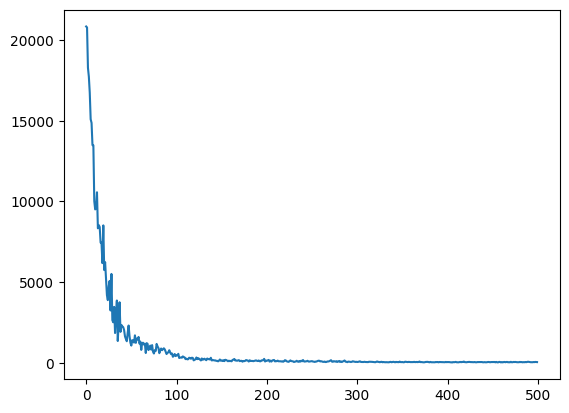

In [54]:
#visualise loss_list
import matplotlib.pyplot as plt
plt.plot(val_loss_list)
plt.show()

In [683]:
print(x_n)

In [456]:
a = Time_embed(64).to(device)
out = a(x_n.to(device))

In [457]:
n_events = x_n.mask.sum(-1)
seq_emb = out.sum(1) / torch.clamp(n_events[..., None], min=1)

In [458]:
seq_emb.shape

torch.Size([3, 64])

In [117]:
out = seq_emb.cpu().detach().numpy()


In [118]:
out = out
#use pca to reduce the dimentionality to 1
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
out = pca.fit_transform(out)

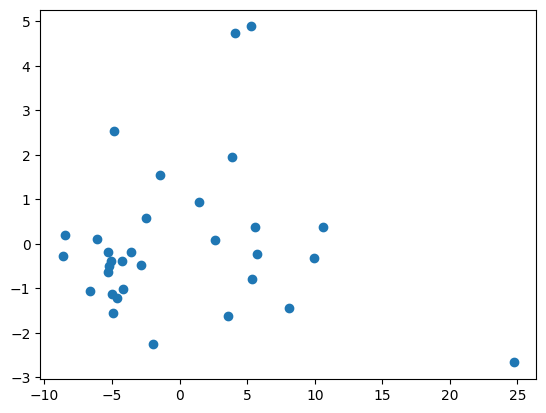

In [119]:
import matplotlib.pyplot as plt
plt.scatter(out[:, 0], out[:, 1])
plt.show()

In [120]:
n

tensor([0.8358, 0.0250, 0.6410, 0.1521, 0.4747, 0.6352, 0.3023, 0.2649, 0.1605,
        0.4678, 0.8366, 0.7202, 0.9508, 0.3766, 0.2682, 0.8674, 0.3451, 0.5874,
        0.2183, 0.1826, 0.7248, 0.3450, 0.2473, 0.8571, 0.7182, 0.5346, 0.4406,
        0.2463, 0.7848, 0.1910, 0.0552, 0.8151])

In [ ]:
from typing import Tuple

import torch
import torch.distributions as D
import torch.nn as nn
import warnings
from torch.distributions import MixtureSameFamily
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked

from add_thin.data import Batch
from add_thin.distributions.densities import DISTRIBUTIONS

patch_typeguard()


@typechecked
class MixtureIntensity(nn.Module):
    """
    Class parameterizing the intensity function as a weighted mixture of distributions.

    Parameters:
    ----------
    n_components : int, optional
        Number of components to use in the mixture, by default 10
    embedding_size : int, optional
        Size of the event embedding, by default 128
    distribution : str, optional
        Distribution to use for the components, by default "normal"

    """

    def __init__(
        self,
        n_components: int = 10,
        embedding_size: int = 128,
        distribution: str = "normal",
    ) -> None:
        super().__init__()

        assert (
            distribution in DISTRIBUTIONS.keys()
        ), f"{distribution} not in {DISTRIBUTIONS.keys()}"
        self.w_activation = torch.nn.Softplus()
        self.distribution = DISTRIBUTIONS[distribution]

        # Parallel compute parameters weight, mu and sigma for n components with one MLP
        self.n_components = n_components
        self.mlp = nn.Sequential(
            nn.Linear(embedding_size, embedding_size),
            nn.ReLU(),
            nn.Linear(embedding_size, 3 * n_components),
        )
        self.rejections_sample_multiple = 2

    def get_intensity_parameters(
        self,
        embs
    ):
        """
        Compute the parameters of the intensity function.

        Parameters:
        ----------
        x_n : Batch
            Batch of event sequences to condition on
        event_emb : TensorType[float, "batch", "seq", "embedding"]
            Context embedding of the events
        dif_time_emb : TensorType[float, "batch", "embedding"]
            Embedding of the diffusion time

        Returns:
        -------
        location, scale, weight: List[TensorType]
            The parameters of the intensity function
        """

        # Compute masked mean over sequence (zero padded)

        parameters = self.mlp(embs)
        return torch.split(
            parameters,
            [self.n_components, self.n_components, self.n_components],
            dim=-1,
        )

    def get_distribution(
        self,
        embs,
        x_n,
        L,
    ):
        """
        Instantiate the mixture-distribution parameterizing the intensity function.

        Parameters:
        ----------
        event_emb : TensorType[float, "batch", "seq", "embedding"]
            Context embedding of the events
        dif_time_emb : TensorType[float, "batch", "embedding"]
            Embedding of the diffusion time
        x_n : Batch
            Batch of event sequences to condition on
        L : int
            Maximum sequence length

        Returns:
        -------
        density, cumulative_intensity: Tuple[D.MixtureSameFamily, TensorType[float, "batch"]]
            The distribution and the cumulative intensity
        """
        location, scale, weight = self.get_intensity_parameters(
            embs
        )

        # Include the number of events in x_n for the cumulative intensity
        weight = self.w_activation(weight)
        cumulative_intensity = (weight).sum(-1) * (x_n.mask.sum(-1) + 1)

        # Probs is normalized to sum to 1
        mixture_dist = D.Categorical(probs=weight.unsqueeze(1).repeat(1, L, 1))

        # Distribution parameters are the same for each sequence element
        component_dist = self.distribution(
            location.unsqueeze(1).repeat(1, L, 1),
            scale.unsqueeze(1).repeat(1, L, 1),
        )
        return (
            MixtureSameFamily(mixture_dist, component_dist),
            cumulative_intensity,
        )

    def log_likelihood(
        self,
        x_0,
        embs,
        x_n,
    ):
        """
        Compute the log-likelihood of the event sequences.

        Parameters:
        ----------
        x_0 : Batch
            Batch of event sequences
        event_emb : TensorType[float, "batch", "seq", "embedding"]
            Context embedding of the events
        dif_time_emb : TensorType[float, "batch", "embedding"]
            Embedding of the diffusion time
        x_n : Batch
            Batch of event sequences to condition on

        Returns:
        -------
        log_likelihood: TensorType[float, "batch"]
            The log-likelihood of the event sequences
        """
        density, cif = self.get_distribution(
            embs=embs,
            x_n=x_n,
            L=x_0.seq_len,
        )

        # Normalize event time to [0, 1]
        x = x_0.time / x_0.tmax

        # Compute log-intensity with re-weighting
        log_intensity = (
            (density.log_prob(x) + torch.log(cif)[..., None]) * x_0.mask
        ).sum(-1)

        # Compute CIF for normalization
        cdf = density.cdf(torch.ones_like(x)).mean(1)
        cif = cif * cdf  # Rescale between 0 and T

        return log_intensity - cif

    def sample(
        self,
        embs,
        n_samples,
        x_n,
    ):
        """
        Sample event sequences from the intensity function.

        Parameters:
        ----------
        event_emb : TensorType[float, "batch", "seq", "embedding"]
            Context embedding of the events
        dif_time_emb : TensorType[float, "batch", "embedding"]
            Embedding of the diffusion time
        n_samples : int
            Number of samples to draw
        x_n : Batch
            Batch of event sequences to condition on

        Returns:
        -------
        Batch
            The sampled event sequences
        """
        tmax = x_n.tmax
        density, cif = self.get_distribution(
            embs=embs,
            x_n=x_n,
            L=1,
        )

        # Get number of points per sample sequence from CIF
        count_distribution = D.Poisson(
            rate=cif * density.cdf(torch.ones_like(x_n.time)).mean().squeeze()
        )
        sequence_len = (
            count_distribution.sample((n_samples,)).squeeze()
        ).long()

        # TODO implement smarter truncated normal, without rejection sampling.
       

        return sequence_len

In [ ]:

    
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)
        
        

In [ ]:
#set detect anomaly to True
with torch.autograd.detect_anomaly():
    train_loss_list = []
    val_loss_list = []
    for epoch in tqdm(range(200)):
        train_batch_list = []
        for batch in train_loader:
            
            optimizer.zero_grad()
            n = torch.randint(low = 1, high = 10, size=(len(batch),), device=batch.time.device)
            #n = torch.ones_like(n) * 3
            #l = n.shape[0]
            #n[:l//3] =a n[:l//3] * 3
            #n[l//3:2*l//3] =  n[l//3:2*l//3] * 2
            #n[2*l//3:] = n[2*l//3:] * 1
            n = n/10 
            x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
            x_n.to(device)
            x_0_thin.to(device)
            preds = model(x_n,n)
            preds = 140 * preds
            
            #mse loss between x_o_thin and preds
            loss = F.mse_loss(preds.squeeze(), x_0_thin.unpadded_length.float())
            #loss = 0
            loss.backward()
            optimizer.step()
            # if epoch is divisble by 100 print the loss
                
            train_batch_list.append(loss.item())
            
        with torch.no_grad():
            #evaluate on val_loader
            val_batch_list = []
            for batch in val_loader:
                n = torch.randint(low = 5, high = 10, size=(len(batch),), device=batch.time.device)
                n = n/10
                x_n, x_0_thin, x_0_kept, hpp_thinned, hpp_kept = add_thin_model.noise(x_0=batch, n=n)
                x_n.to(device)
                x_0_thin.to(device)
                preds = model(x_n,n)
                preds = 140 * preds
                loss = F.mse_loss(preds.squeeze(), x_0_thin.unpadded_length.float())
                val_batch_list.append(loss.item())
            print("epoch: ", epoch, "val_loss: ", sum(val_batch_list)/len(val_batch_list))
            
        train_loss_list.append(sum(train_batch_list)/len(train_batch_list))
        val_loss_list.append(sum(val_batch_list)/len(val_batch_list))
        if epoch % 10 == 0:
                #print("epoch: ", epoch, "train_loss: ", train_loss_list[-1])
                print("epoch: ", epoch, "val_loss: ", val_loss_list[-1])
        
        

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class CVAE1D(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(CVAE1D, self).__init__()
        self.input_dim = input_dim

        # Encoder layers
        self.encoder_fc1 = nn.Linear(2 * input_dim, hidden_dim)
        self.encoder_fc2_mean = nn.Linear(hidden_dim, hidden_dim)
        self.encoder_fc2_logvar = nn.Linear(hidden_dim, hidden_dim)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, 1)

    def encode(self, x, context):
        # Concatenate input x with context embeddings
        x = torch.cat([x, context], dim=1)
        x = F.relu(self.encoder_fc1(x))
        z_mean = self.encoder_fc2_mean(x)
        z_logvar = self.encoder_fc2_logvar(x)
        return z_mean, z_logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, context):
        # Concatenate latent z with context embeddings
        z = torch.cat([z, context], dim=1)
        z = F.relu(self.decoder_fc1(z))
        x_recon = torch.sigmoid(self.decoder_fc2(z))  # Sigmoid activation for output
        return x_recon

    def forward(self, x, context):
        # Encode
        z_mean, z_logvar = self.encode(x, context)
        # Reparameterize
        z = self.reparameterize(z_mean, z_logvar)
        # Decode
        x_recon = self.decode(z, context)
        return x_recon, z_mean, z_logvar

    def sample(self, num_samples, context):
        # Sample from the prior and decode
        z = torch.randn(num_samples, self.latent_dim).to(context.device)
        x_recon = self.decode(z, context)
        return x_recon
